# Geometric Transformers

You can run this notebook directly on Google Colab

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DaniAffCH/Vessel-Geometric-Transformers/blob/main/main.ipynb)

## Index

### Geometric Algebra 
- [geometricAlgebraElements](https://github.com/DaniAffCH/Vessel-Geometric-Transformers/blob/main/src/lib/geometricAlgebraElements.py) defines how geometric objects and transformations can be embedded into projective geometric algebra
- [geometricAlgebraOperations](https://github.com/DaniAffCH/Vessel-Geometric-Transformers/blob/main/src/lib/geometricAlgebraOperations.py) defines operations between multivectors

### [Dataset](#dataset) 
- [dataset](https://github.com/DaniAffCH/Vessel-Geometric-Transformers/blob/main/src/data/dataset.py) downloads the dataset into .hdf5 files and shuffles the labels 
- [datamodule](https://github.com/DaniAffCH/Vessel-Geometric-Transformers/blob/main/src/data/datamodule.py) is the class where raw data is embedded into geometric algebra and then collected into batches by the dataloaders

### Layers
- [default](https://github.com/DaniAffCH/Vessel-Geometric-Transformers/blob/main/src/models/layers/default) where layers for the baseline transformer are implemented
- [geometric](https://github.com/DaniAffCH/Vessel-Geometric-Transformers/blob/main/src/models/layers/geometric) where all the layers equivariant to the E(3) symmetry group are implemented

### [Equivariance](#equivariance-check)
- [equivariance](https://github.com/DaniAffCH/Vessel-Geometric-Transformers/blob/main/src/lib/equivariance.py) check utility functions, where transformations against which equivariance must hold are implemented
- [tests](https://github.com/DaniAffCH/Vessel-Geometric-Transformers/blob/main/src/test/test_equivariance.py) to check equivariance

### [Models](https://github.com/DaniAffCH/Vessel-Geometric-Transformers/blob/main/src/models)

In [1]:
import sys
import warnings

warnings.filterwarnings('ignore')

COLAB_RUNTIME = 'google.colab' in sys.modules
!nvidia-smi &> /dev/null || echo -e "\e[31mWarning: No GPU found. Please check your runtime settings.\e[0m"
if COLAB_RUNTIME:
    !git config --global init.defaultBranch main
    !git init
    !git remote add origin https://github.com/DaniAffCH/Vessel-Geometric-Transformers.git
    !git pull origin main
    !pip install -q -r requirements.txt
else: # Development mode, setting precommit checks 
    !pip install -q -r requirements.txt
    !pre-commit autoupdate
    !pre-commit install



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
[https://github.com/psf/black] already up to date!
[https://github.com/pycqa/isort] already up to date!
[https://github.com/PyCQA/flake8] already up to date!
[https://github.com/pre-commit/mirrors-mypy] already up to date!
pre-commit installed at .git/hooks/pre-commit


---

### Loading the configuration
- You can change by modifying this [yaml](https://github.com/DaniAffCH/Vessel-Geometric-Transformers/blob/main/config/config.yaml) file
- New entries should be added also [here](https://github.com/DaniAffCH/Vessel-Geometric-Transformers/blob/main/config/dataclasses.py)

In [ ]:
from src.utils import load_config
import os
from lightning import seed_everything

config_path = os.path.join("config","config.yaml")
config = load_config(config_path)
seed_everything(config.seed)

---

### Loading the dataset
Showing data shapes and label distribution to check whether train, validation and test set are balanced

Train size: 2999
Val size: 599
Test size: 401
One Sample: Data(pos=[16537, 3], wss=[16537, 3], pressure=[16537], face=[3, 33070], inlet_index=[818], label=Category.Bifurcating)


100%|██████████| 3999/3999 [00:05<00:00, 785.85it/s]


,Mean,Median,Std,Min,Max
WSS,13011.76019,11387.0,4271.667184,5466,24800
POS,13011.76019,11387.0,4271.667184,5466,24800
FACE,26019.52038,22770.0,8543.334368,10928,49596
PRESSURE,13011.76019,11387.0,4271.667184,5466,24800


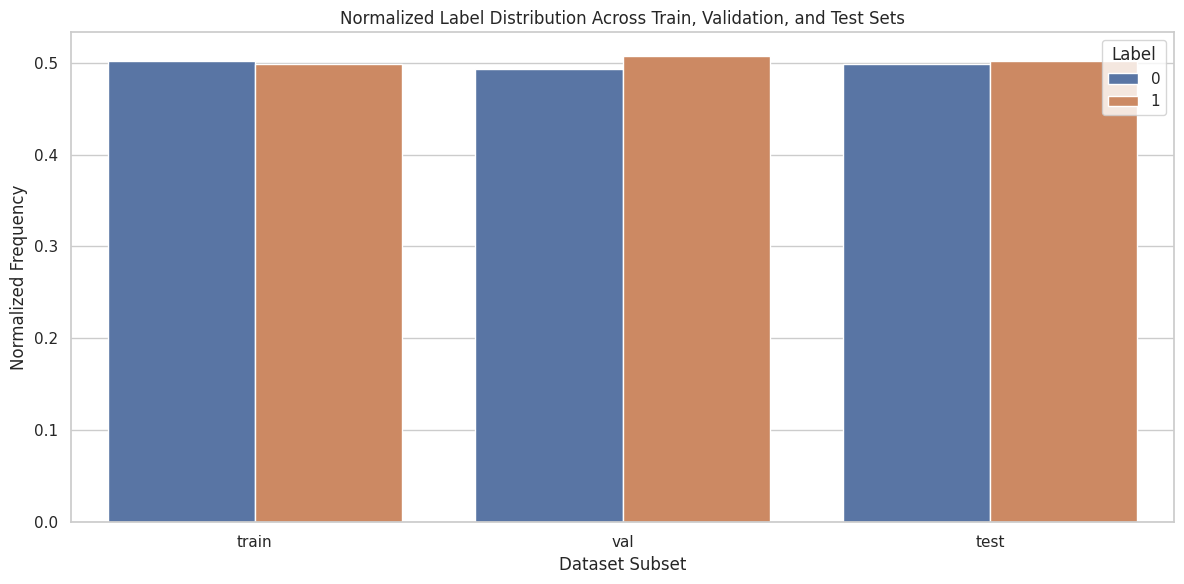

In [ ]:
from src.data import VesselDataModule
from src.utils.data_analysis import data_info, check_class_distribution

data = VesselDataModule(config.dataset)
data_info(data)
check_class_distribution(data)

Plotting the data distribution projected in 2D using Principal Component Analysis.

Extracting Feature.FACE: 100%|██████████| 3999/3999 [00:04<00:00, 898.30it/s] 


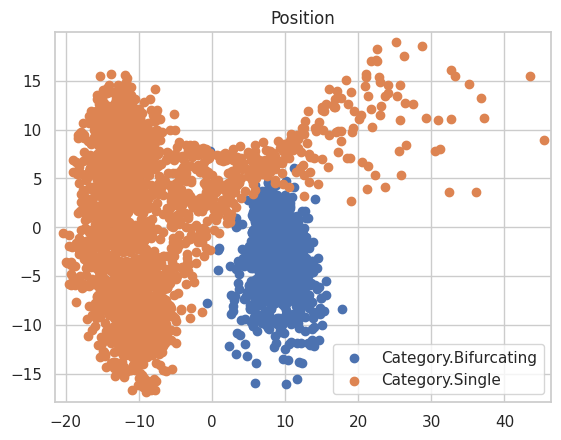

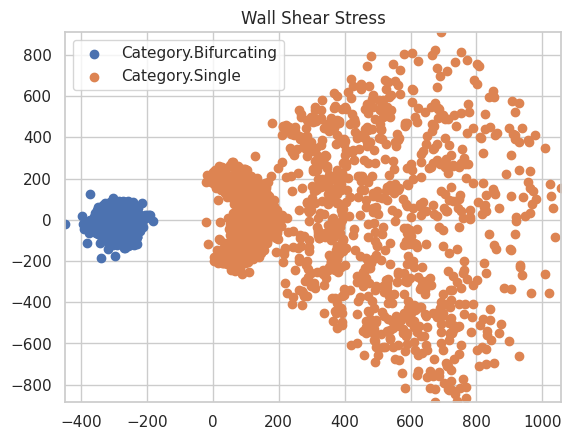

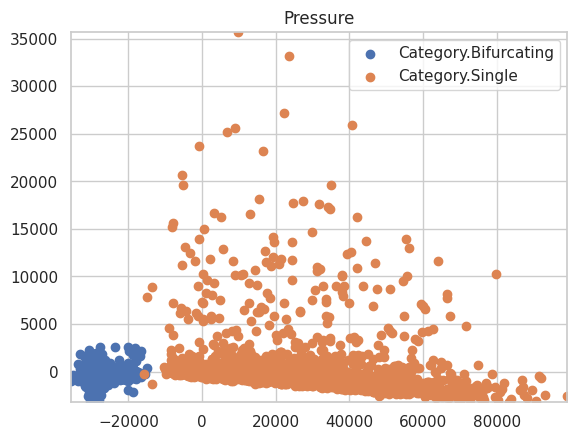

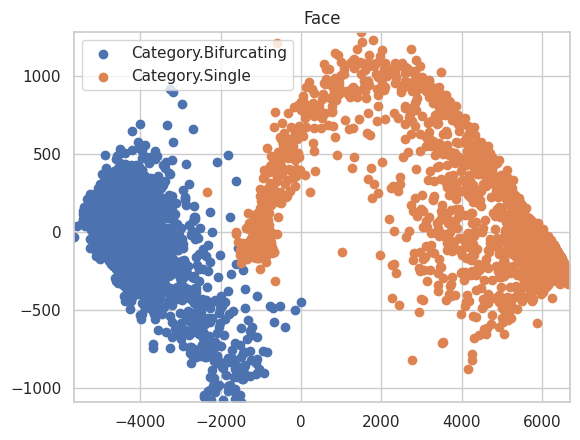

In [ ]:
from src.utils.definitions import Feature, Category
from src.utils.data_analysis import plot_data

wss, labels = data.extract_feature(Feature.WSS)
pos, labels = data.extract_feature(Feature.POS)
pressure, labels = data.extract_feature(Feature.PRESSURE)
face, labels = data.extract_feature(Feature.FACE)
plot_data(pos, labels, Category, "Position")
plot_data(wss, labels, Category, "Wall Shear Stress")
plot_data(pressure, labels, Category, "Pressure")
plot_data(face, labels, Category, "Face")

---

### Equivariance Check
Performing equivariance check using random samples from the dataset.  
Geometric Layer is expected to fail due to lack of distance-aware dot product

In [ ]:
from src.lib.geometricAlgebraElements import GeometricAlgebraBase
from src.test.test_equivariance import TestEquivariance
import unittest

dl = data.train_dataloader()
batch = next(iter(dl)).data[0]
batch = batch.view(-1, GeometricAlgebraBase.GA_size)[:10] # Flattening and taking only the first 10 elements
TestEquivariance.INPUT_DATA = batch # Setting the input data for the test

suite = unittest.TestSuite()
suite.addTests(unittest.TestLoader().loadTestsFromTestCase(TestEquivariance))
test_runner = unittest.TextTestRunner(verbosity=0)
restResult = test_runner.run(suite)

torch.Size([10, 16])


/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/.venv/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/.venv/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)



✅ GeometricBilinearLayer passed all equivariance tests               with a tolerance of 1e-05.              [10 inputs, 100 checks each]

✅ EquiLinearLayer passed all equivariance tests               with a tolerance of 1e-05.              [10 inputs, 100 checks each]

✅ EquiNormLayer passed all equivariance tests               with a tolerance of 1e-05.              [10 inputs, 100 checks each]


FAIL: test_geomattention_layer (src.test.test_equivariance.TestEquivariance)
Tests the equivariance of the GeometricAttentionLayer.
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/src/test/test_equivariance.py", line 125, in test_geomattention_layer
    self.assertTrue(
AssertionError: False is not true : GeometricAttentionLayer failed the equivariance                     test for input 1

----------------------------------------------------------------------
Ran 5 tests in 6.861s

FAILED (failures=1)



✅ GatedGELU passed all equivariance tests               with a tolerance of 1e-05.              [10 inputs, 100 checks each]


---

### MLP Baseline

Running hyperparameter optimization to find the best hyperparameters maximizing the validation accuracy

In [ ]:
from src.utils.hpo import mlp_hpo

mlp_hpo(config, data) # Hyperparameter optimization: writes the config file with the best hyperparameters

[I 2024-10-31 11:25:11,379] A new study created in memory with name: baseline_hpo
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | loss_fn        | BCEWithLogitsLoss  | 0      | train
1 | train_accuracy | BinaryAccuracy     | 0      | train
2 | val_accuracy   | BinaryAccuracy     | 0      | train
3 | test_accuracy  | BinaryAccuracy     | 0      | train
4 | train_f1       | BinaryF1Score      | 0      | train
5 | val_f1         | BinaryF1Score      | 0      | train
6 | test_f1        | BinaryF1Score      | 0      | train
7 | encoder        | TransformerEncoder | 2.2 K  | train
8 | embedder       | Linear             | 272    | train
9 | projection     | Linear             | 19.2 K | train
--------------------------------------------------------------
21.7 K

Starting a new hyperparameter optimization study...
Starting a new trial...
Trial number: 0
Learning rate: 0.001
Batch Size: 8
Epoch 1:  60%|██████    | 226/375 [00:09<00:06, 24.32it/s, v_num=103, val/loss=0.104, val/acc=0.968, val/f1=0.967, train/loss=0.431, train/acc=0.837, train/f1=0.840]

[I 2024-10-31 11:25:39,087] Trial 0 finished with value: 0.10437805205583572 and parameters: {'lr': 0.0024713734184878826, 'hidden_size': 16, 'batch_size': 8}. Best is trial 0 with value: 0.10437805205583572.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial 0 finished with value 0.10437805205583572
Starting a new trial...
Trial number: 1
Learning rate: 0.001
Batch Size: 16



  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | loss_fn        | BCEWithLogitsLoss  | 0      | train
1 | train_accuracy | BinaryAccuracy     | 0      | train
2 | val_accuracy   | BinaryAccuracy     | 0      | train
3 | test_accuracy  | BinaryAccuracy     | 0      | train
4 | train_f1       | BinaryF1Score      | 0      | train
5 | val_f1         | BinaryF1Score      | 0      | train
6 | test_f1        | BinaryF1Score      | 0      | train
7 | encoder        | TransformerEncoder | 2.2 K  | train
8 | embedder       | Linear             | 272    | train
9 | projection     | Linear             | 19.2 K | train
--------------------------------------------------------------
21.7 K    Trainable params
0         Non-trainable params
21.7 K    Total params
0.087     Total estimated model params size (MB)


Epoch 0:  66%|██████▋   | 125/188 [00:09<00:04, 12.86it/s, v_num=104]      

Training the model using the best hyperparameters

In [ ]:
from src.trainer import VesselTrainer
from src.models import BaselineMLP

model = BaselineMLP(config.mlp)
trainer = VesselTrainer(config.trainer, "mlp")
trainer.fit(model, data)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: neverorfrog (neverorfrog-sapienza). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/daniaffch/.netrc


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | loss_fn        | BCEWithLogitsLoss | 0      | train
1 | train_accuracy | BinaryAccuracy    | 0      | train
2 | val_accuracy   | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | train_f1       | BinaryF1Score     | 0      | train
5 | val_f1         | BinaryF1Score     | 0      | train
6 | test_f1        | BinaryF1Score     | 0      | train
7 | fc             | Sequential        | 614 K  | train
-------------------------------------------------------------
614 K     Trainable params
0         Non-trainable params
614 K     Total params
2.460     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 750/750 [00:12<00:00, 61.91it/s, v_num=dz92, val/loss=0.0126, val/acc=0.992, val/f1=0.992, train/loss=0.0771, train/acc=0.973, train/f1=0.973]

Metric val/loss improved. New best score: 0.013
Epoch 0, global step 750: 'val/loss' reached 0.01259 (best 0.01259), saving model to '/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=0-step=750-v1.ckpt' as top 1


Epoch 1: 100%|██████████| 750/750 [00:12<00:00, 59.33it/s, v_num=dz92, val/loss=0.0323, val/acc=0.990, val/f1=0.990, train/loss=0.0173, train/acc=0.996, train/f1=0.996]

Epoch 1, global step 1500: 'val/loss' was not in top 1


Epoch 2: 100%|██████████| 750/750 [00:13<00:00, 53.60it/s, v_num=dz92, val/loss=0.101, val/acc=0.972, val/f1=0.972, train/loss=0.0212, train/acc=0.993, train/f1=0.993] 

Epoch 2, global step 2250: 'val/loss' was not in top 1


Epoch 3: 100%|██████████| 750/750 [00:13<00:00, 54.11it/s, v_num=dz92, val/loss=0.0106, val/acc=0.998, val/f1=0.998, train/loss=0.0241, train/acc=0.993, train/f1=0.993]

Metric val/loss improved by 0.002 >= min_delta = 1e-05. New best score: 0.011
Epoch 3, global step 3000: 'val/loss' reached 0.01058 (best 0.01058), saving model to '/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=3-step=3000.ckpt' as top 1


Epoch 4: 100%|██████████| 750/750 [00:13<00:00, 57.68it/s, v_num=dz92, val/loss=0.00411, val/acc=1.000, val/f1=1.000, train/loss=0.0115, train/acc=0.996, train/f1=0.996]

Metric val/loss improved by 0.006 >= min_delta = 1e-05. New best score: 0.004
Epoch 4, global step 3750: 'val/loss' reached 0.00411 (best 0.00411), saving model to '/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=4-step=3750.ckpt' as top 1


Epoch 5: 100%|██████████| 750/750 [00:12<00:00, 61.20it/s, v_num=dz92, val/loss=0.00114, val/acc=1.000, val/f1=1.000, train/loss=0.00813, train/acc=0.996, train/f1=0.996]

Metric val/loss improved by 0.003 >= min_delta = 1e-05. New best score: 0.001
Epoch 5, global step 4500: 'val/loss' reached 0.00114 (best 0.00114), saving model to '/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=5-step=4500.ckpt' as top 1


Epoch 6: 100%|██████████| 750/750 [00:12<00:00, 59.31it/s, v_num=dz92, val/loss=0.00129, val/acc=1.000, val/f1=1.000, train/loss=0.0125, train/acc=0.997, train/f1=0.997] 

Epoch 6, global step 5250: 'val/loss' was not in top 1


Epoch 7: 100%|██████████| 750/750 [00:12<00:00, 58.82it/s, v_num=dz92, val/loss=0.00498, val/acc=0.998, val/f1=0.998, train/loss=0.0124, train/acc=0.997, train/f1=0.997]

Epoch 7, global step 6000: 'val/loss' was not in top 1


Epoch 8: 100%|██████████| 750/750 [00:13<00:00, 57.25it/s, v_num=dz92, val/loss=0.000525, val/acc=1.000, val/f1=1.000, train/loss=0.00291, train/acc=0.999, train/f1=0.999]

Metric val/loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.001
Epoch 8, global step 6750: 'val/loss' reached 0.00052 (best 0.00052), saving model to '/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=8-step=6750.ckpt' as top 1


Epoch 9: 100%|██████████| 750/750 [00:12<00:00, 60.89it/s, v_num=dz92, val/loss=0.000408, val/acc=1.000, val/f1=1.000, train/loss=0.00557, train/acc=0.998, train/f1=0.998]

Metric val/loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.000
Epoch 9, global step 7500: 'val/loss' reached 0.00041 (best 0.00041), saving model to '/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=9-step=7500-v2.ckpt' as top 1


Epoch 10: 100%|██████████| 750/750 [00:11<00:00, 65.13it/s, v_num=dz92, val/loss=0.00109, val/acc=1.000, val/f1=1.000, train/loss=0.00521, train/acc=0.998, train/f1=0.998] 

Epoch 10, global step 8250: 'val/loss' was not in top 1


Epoch 11: 100%|██████████| 750/750 [00:11<00:00, 65.17it/s, v_num=dz92, val/loss=0.00216, val/acc=1.000, val/f1=1.000, train/loss=0.0284, train/acc=0.990, train/f1=0.990] 

Epoch 11, global step 9000: 'val/loss' was not in top 1


Epoch 12: 100%|██████████| 750/750 [00:11<00:00, 64.51it/s, v_num=dz92, val/loss=0.00809, val/acc=0.997, val/f1=0.997, train/loss=0.0075, train/acc=0.997, train/f1=0.997]

Monitored metric val/loss did not improve in the last 3 records. Best score: 0.000. Signaling Trainer to stop.
Epoch 12, global step 9750: 'val/loss' was not in top 1


Epoch 12: 100%|██████████| 750/750 [00:11<00:00, 64.49it/s, v_num=dz92, val/loss=0.00809, val/acc=0.997, val/f1=0.997, train/loss=0.0075, train/acc=0.997, train/f1=0.997]


Test the model performance on unseen test data.

Restoring states from the checkpoint path at /home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=9-step=7500-v2.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=9-step=7500-v2.ckpt


Testing DataLoader 0: 100%|██████████| 101/101 [00:00<00:00, 103.99it/s]

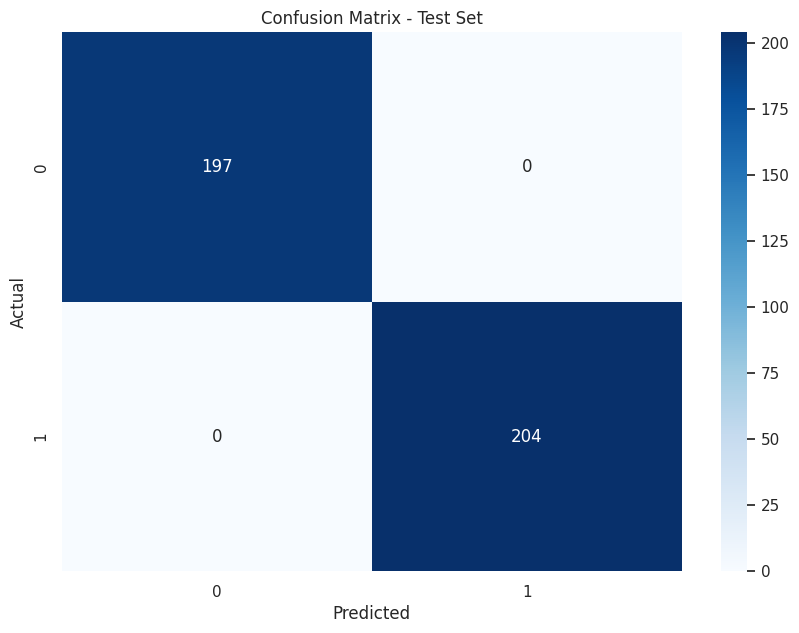

Testing DataLoader 0: 100%|██████████| 101/101 [00:01<00:00, 86.02it/s] 


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │            1.0            │
│          test/f1          │            1.0            │
│         test/loss         │   0.0007055738242343068   │
└───────────────────────────┴───────────────────────────┘

In [ ]:
trainer.test(model, data)

### Attention based Baseline

Running hyperparameter optimization to find the best hyperparameters maximizing the validation accuracy

In [ ]:
from src.utils.hpo import baseline_hpo

baseline_hpo(config, data) # Hyperparameter optimization: writes the config file with the best hyperparameters

[I 2024-10-31 10:46:36,272] A new study created in memory with name: baseline_hpo
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | loss_fn        | BCEWithLogitsLoss  | 0      | train
1 | train_accuracy | BinaryAccuracy     | 0      | train
2 | val_accuracy   | BinaryAccuracy     | 0      | train
3 | test_accuracy  | BinaryAccuracy     | 0      | train
4 | train_f1       | BinaryF1Score      | 0      | train
5 | val_f1         | BinaryF1Score      | 0      | train
6 | test_f1        | BinaryF1Score      | 0      | train
7 | encoder        | TransformerEncoder | 2.2 K  | train
8 | embedder       | Linear             | 272    | train
9 | projection     | Linear             | 19.2 K | train
--------------------------------------------------------------
21.7 K

Starting a new hyperparameter optimization study...
Starting a new trial...
Trial number: 0
Learning rate: 0.012285916427548801
Attention Heads: 8
Attention Layers: 3
Batch Size: 4
Epoch 3: 100%|██████████| 750/750 [00:22<00:00, 33.24it/s, v_num=95, val/loss=2.43e-5, val/acc=1.000, val/f1=1.000, train/loss=9.45e-6, train/acc=1.000, train/f1=1.000]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 750/750 [00:22<00:00, 33.22it/s, v_num=95, val/loss=2.43e-5, val/acc=1.000, val/f1=1.000, train/loss=9.45e-6, train/acc=1.000, train/f1=1.000]


[I 2024-10-31 10:48:02,127] Trial 0 finished with value: 2.431407483527437e-05 and parameters: {'lr': 0.012285916427548801, 'num_heads': 8, 'num_layers': 3, 'batch_size': 4}. Best is trial 0 with value: 2.431407483527437e-05.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | loss_fn        | BCEWithLogitsLoss  | 0      | train
1 | train_accuracy | BinaryAccuracy     | 0      | train
2 | val_accuracy   | BinaryAccuracy     | 0      | train
3 | test_accuracy  | BinaryAccuracy     | 0      | train
4 | train_f1       | BinaryF1Score      | 0      | train
5 | val_f1         | BinaryF1Score      | 0      | train
6 | test_f1        | BinaryF1Score      | 0      | train
7 | encoder        | TransformerEncoder | 2.2 K  | train
8 | embedder       | Linear            

Trial 0 finished with value 2.431407483527437e-05
Starting a new trial...
Trial number: 1
Learning rate: 0.0010703702960745563
Attention Heads: 2
Attention Layers: 2
Batch Size: 16
Epoch 3: 100%|██████████| 188/188 [00:17<00:00, 10.96it/s, v_num=96, val/loss=8.11e-6, val/acc=1.000, val/f1=1.000, train/loss=1.49e-6, train/acc=1.000, train/f1=1.000]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 188/188 [00:17<00:00, 10.95it/s, v_num=96, val/loss=8.11e-6, val/acc=1.000, val/f1=1.000, train/loss=1.49e-6, train/acc=1.000, train/f1=1.000]


[I 2024-10-31 10:49:13,704] Trial 1 finished with value: 8.109707778203301e-06 and parameters: {'lr': 0.0010703702960745563, 'num_heads': 2, 'num_layers': 2, 'batch_size': 16}. Best is trial 1 with value: 8.109707778203301e-06.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | loss_fn        | BCEWithLogitsLoss  | 0      | train
1 | train_accuracy | BinaryAccuracy     | 0      | train
2 | val_accuracy   | BinaryAccuracy     | 0      | train
3 | test_accuracy  | BinaryAccuracy     | 0      | train
4 | train_f1       | BinaryF1Score      | 0      | train
5 | val_f1         | BinaryF1Score      | 0      | train
6 | test_f1        | BinaryF1Score      | 0      | train
7 | encoder        | TransformerEncoder | 2.2 K  | train
8 | embedder       | Linear          

Trial 1 finished with value 8.109707778203301e-06
Starting a new trial...
Trial number: 2
Learning rate: 0.008002079756292479
Attention Heads: 2
Attention Layers: 1
Batch Size: 16
Epoch 3: 100%|██████████| 188/188 [00:17<00:00, 10.79it/s, v_num=97, val/loss=3.22e-9, val/acc=1.000, val/f1=1.000, train/loss=8.3e-11, train/acc=1.000, train/f1=1.000]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 188/188 [00:17<00:00, 10.78it/s, v_num=97, val/loss=3.22e-9, val/acc=1.000, val/f1=1.000, train/loss=8.3e-11, train/acc=1.000, train/f1=1.000]


[I 2024-10-31 10:50:26,800] Trial 2 finished with value: 3.218520783221379e-09 and parameters: {'lr': 0.008002079756292479, 'num_heads': 2, 'num_layers': 1, 'batch_size': 16}. Best is trial 2 with value: 3.218520783221379e-09.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | loss_fn        | BCEWithLogitsLoss  | 0      | train
1 | train_accuracy | BinaryAccuracy     | 0      | train
2 | val_accuracy   | BinaryAccuracy     | 0      | train
3 | test_accuracy  | BinaryAccuracy     | 0      | train
4 | train_f1       | BinaryF1Score      | 0      | train
5 | val_f1         | BinaryF1Score      | 0      | train
6 | test_f1        | BinaryF1Score      | 0      | train
7 | encoder        | TransformerEncoder | 2.2 K  | train
8 | embedder       | Linear           

Trial 2 finished with value 3.218520783221379e-09
Starting a new trial...
Trial number: 3
Learning rate: 0.00018893604491749283
Attention Heads: 8
Attention Layers: 3
Batch Size: 8
Epoch 3: 100%|██████████| 375/375 [00:19<00:00, 19.62it/s, v_num=98, val/loss=2.33e-11, val/acc=1.000, val/f1=1.000, train/loss=4.08e-11, train/acc=1.000, train/f1=1.000]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 375/375 [00:19<00:00, 19.61it/s, v_num=98, val/loss=2.33e-11, val/acc=1.000, val/f1=1.000, train/loss=4.08e-11, train/acc=1.000, train/f1=1.000]


[I 2024-10-31 10:51:43,649] Trial 3 finished with value: 2.3308001362298825e-11 and parameters: {'lr': 0.00018893604491749283, 'num_heads': 8, 'num_layers': 3, 'batch_size': 8}. Best is trial 3 with value: 2.3308001362298825e-11.


Trial 3 finished with value 2.3308001362298825e-11
Hyperparameter optimization completed.
Best hyperparameters found:
          Learning rate: 0.00018893604491749283
          Number of Attention Heads: 8
          Number of Attention Layers: 3
          Batch Size: 8



Training the model using the best hyperparameters

In [ ]:
from src.trainer import VesselTrainer
from src.models import BaselineTransformer

model = BaselineTransformer(config.baseline)
trainer = VesselTrainer(config.trainer, "transformer")
trainer.fit(model, data)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇█
test/acc,▁
test/f1,▁
test/loss,▁
train/acc,▁▇▆▆▇▇▇▇███▆▇
train/f1,▁▇▆▆▇▇▇▇███▆▇
train/loss,█▂▃▃▂▁▂▂▁▁▁▃▁
trainer/global_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▆▆▆▆▇▇▇▇███
val/acc,▆▆▁█████████▇
val/f1,▆▅▁█████████▇
val/loss,▂▃█▂▁▁▁▁▁▁▁▁▂


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | loss_fn        | BCEWithLogitsLoss  | 0      | train
1 | train_accuracy | BinaryAccuracy     | 0      | train
2 | val_accuracy   | BinaryAccuracy     | 0      | train
3 | test_accuracy  | BinaryAccuracy     | 0      | train
4 | train_f1       | BinaryF1Score      | 0      | train
5 | val_f1         | BinaryF1Score      | 0      | train
6 | test_f1        | BinaryF1Score      | 0      | train
7 | encoder        | TransformerEncoder | 6.7 K  | train
8 | embedder       | Linear             | 272    | train
9 | projection     | Linear             | 19.2 K | train
--------------------------------------------------------------
26.2 K    Trainable params
0         Non-trainable params
26.2 K    Total params
0.105  

Epoch 0: 100%|██████████| 375/375 [01:24<00:00,  4.46it/s, v_num=rw89, val/loss=0.257, val/acc=0.913, val/f1=0.918, train/loss=0.319, train/acc=0.834, train/f1=0.838]

Metric val/loss improved. New best score: 0.257
Epoch 0, global step 375: 'val/loss' reached 0.25718 (best 0.25718), saving model to '/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=0-step=375.ckpt' as top 1


Epoch 1: 100%|██████████| 375/375 [01:24<00:00,  4.45it/s, v_num=rw89, val/loss=0.0914, val/acc=0.968, val/f1=0.968, train/loss=0.118, train/acc=0.957, train/f1=0.958]

Metric val/loss improved by 0.166 >= min_delta = 1e-05. New best score: 0.091
Epoch 1, global step 750: 'val/loss' reached 0.09144 (best 0.09144), saving model to '/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=1-step=750.ckpt' as top 1


Epoch 2: 100%|██████████| 375/375 [01:25<00:00,  4.40it/s, v_num=rw89, val/loss=0.338, val/acc=0.896, val/f1=0.904, train/loss=0.117, train/acc=0.961, train/f1=0.961] 

Epoch 2, global step 1125: 'val/loss' was not in top 1


Epoch 3: 100%|██████████| 375/375 [01:24<00:00,  4.43it/s, v_num=rw89, val/loss=0.214, val/acc=0.930, val/f1=0.933, train/loss=0.100, train/acc=0.966, train/f1=0.966]

Epoch 3, global step 1500: 'val/loss' was not in top 1


Epoch 4: 100%|██████████| 375/375 [01:24<00:00,  4.41it/s, v_num=rw89, val/loss=0.0663, val/acc=0.978, val/f1=0.978, train/loss=0.0825, train/acc=0.971, train/f1=0.971]

Metric val/loss improved by 0.025 >= min_delta = 1e-05. New best score: 0.066
Epoch 4, global step 1875: 'val/loss' reached 0.06629 (best 0.06629), saving model to '/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=4-step=1875.ckpt' as top 1


Epoch 5: 100%|██████████| 375/375 [01:25<00:00,  4.40it/s, v_num=rw89, val/loss=0.066, val/acc=0.977, val/f1=0.977, train/loss=0.0803, train/acc=0.975, train/f1=0.975] 

Metric val/loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.066
Epoch 5, global step 2250: 'val/loss' reached 0.06600 (best 0.06600), saving model to '/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=5-step=2250.ckpt' as top 1


Epoch 6: 100%|██████████| 375/375 [01:25<00:00,  4.40it/s, v_num=rw89, val/loss=0.0642, val/acc=0.980, val/f1=0.980, train/loss=0.0806, train/acc=0.973, train/f1=0.973]

Metric val/loss improved by 0.002 >= min_delta = 1e-05. New best score: 0.064
Epoch 6, global step 2625: 'val/loss' reached 0.06419 (best 0.06419), saving model to '/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=6-step=2625.ckpt' as top 1


Epoch 7: 100%|██████████| 375/375 [01:24<00:00,  4.45it/s, v_num=rw89, val/loss=0.143, val/acc=0.942, val/f1=0.937, train/loss=0.0679, train/acc=0.977, train/f1=0.977] 

Epoch 7, global step 3000: 'val/loss' was not in top 1


Epoch 8: 100%|██████████| 375/375 [01:24<00:00,  4.44it/s, v_num=rw89, val/loss=0.0638, val/acc=0.975, val/f1=0.974, train/loss=0.0771, train/acc=0.974, train/f1=0.975]

Metric val/loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.064
Epoch 8, global step 3375: 'val/loss' reached 0.06384 (best 0.06384), saving model to '/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=8-step=3375.ckpt' as top 1


Epoch 9: 100%|██████████| 375/375 [01:24<00:00,  4.42it/s, v_num=rw89, val/loss=0.0953, val/acc=0.970, val/f1=0.970, train/loss=0.0597, train/acc=0.978, train/f1=0.979]

Epoch 9, global step 3750: 'val/loss' was not in top 1


Epoch 10: 100%|██████████| 375/375 [01:24<00:00,  4.44it/s, v_num=rw89, val/loss=0.0537, val/acc=0.982, val/f1=0.982, train/loss=0.0625, train/acc=0.978, train/f1=0.978]

Metric val/loss improved by 0.010 >= min_delta = 1e-05. New best score: 0.054
Epoch 10, global step 4125: 'val/loss' reached 0.05366 (best 0.05366), saving model to '/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=10-step=4125.ckpt' as top 1


Epoch 11: 100%|██████████| 375/375 [01:24<00:00,  4.42it/s, v_num=rw89, val/loss=0.0474, val/acc=0.985, val/f1=0.985, train/loss=0.0582, train/acc=0.979, train/f1=0.979]

Metric val/loss improved by 0.006 >= min_delta = 1e-05. New best score: 0.047
Epoch 11, global step 4500: 'val/loss' reached 0.04737 (best 0.04737), saving model to '/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=11-step=4500.ckpt' as top 1


Epoch 12: 100%|██████████| 375/375 [01:24<00:00,  4.45it/s, v_num=rw89, val/loss=0.0426, val/acc=0.985, val/f1=0.985, train/loss=0.052, train/acc=0.981, train/f1=0.981] 

Metric val/loss improved by 0.005 >= min_delta = 1e-05. New best score: 0.043
Epoch 12, global step 4875: 'val/loss' reached 0.04257 (best 0.04257), saving model to '/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=12-step=4875.ckpt' as top 1


Epoch 13: 100%|██████████| 375/375 [01:24<00:00,  4.44it/s, v_num=rw89, val/loss=0.0783, val/acc=0.972, val/f1=0.972, train/loss=0.0474, train/acc=0.983, train/f1=0.983]

Epoch 13, global step 5250: 'val/loss' was not in top 1


Epoch 14: 100%|██████████| 375/375 [01:24<00:00,  4.43it/s, v_num=rw89, val/loss=0.0466, val/acc=0.987, val/f1=0.986, train/loss=0.0547, train/acc=0.982, train/f1=0.982]

Epoch 14, global step 5625: 'val/loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 375/375 [01:24<00:00,  4.43it/s, v_num=rw89, val/loss=0.0466, val/acc=0.987, val/f1=0.986, train/loss=0.0547, train/acc=0.982, train/f1=0.982]


Test the model performance on unseen test data.

Restoring states from the checkpoint path at /home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=12-step=4875.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=12-step=4875.ckpt


Testing DataLoader 0: 100%|██████████| 51/51 [00:04<00:00, 10.64it/s]

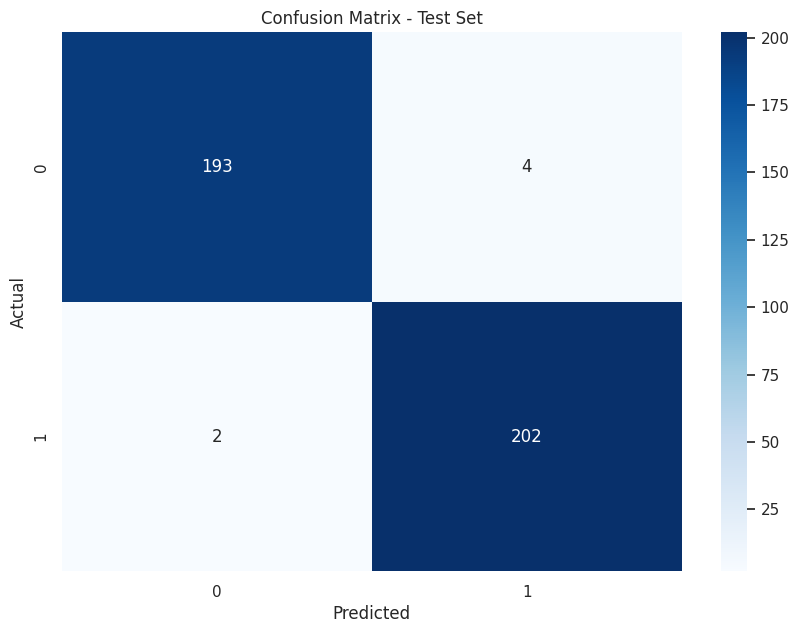

Testing DataLoader 0: 100%|██████████| 51/51 [00:05<00:00, 10.14it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │    0.9850373864173889     │
│          test/f1          │    0.9853658676147461     │
│         test/loss         │    0.04876132681965828    │
└───────────────────────────┴───────────────────────────┘

In [ ]:
trainer.test(model, data)

---

### GATr

Running hyperparameter optimization to find the best hyperparameters maximizing the validation accuracy

In [ ]:
from src.models import Gatr
from src.utils.hpo import gatr_hpo

gatr_hpo(config, data) # Hyperparameter optimization: writes the config file with the best hyperparameters

[I 2024-10-31 11:13:10,974] A new study created in memory with name: gatr_hpo
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type              | Params | Mode 
--------------------------------------------------------------
0 | loss_fn         | BCEWithLogitsLoss | 0      | train
1 | train_accuracy  | BinaryAccuracy    | 0      | train
2 | val_accuracy    | BinaryAccuracy    | 0      | train
3 | test_accuracy   | BinaryAccuracy    | 0      | train
4 | train_f1        | BinaryF1Score     | 0      | train
5 | val_f1          | BinaryF1Score     | 0      | train
6 | test_f1         | BinaryF1Score     | 0      | train
7 | hsProjection    | EquiLinearLayer   | 576    | train
8 | backbone        | ModuleList        | 25.3 K | train
9 | finalProjection | Linear            | 76.8 K | train
--------------------------------------------------------------
102 K     

Starting a new hyperparameter optimization study...
Starting a new trial...
Trial number: 0
Learning rate: 0.012285916427548801
Attention Heads: 8
Attention Layers: 3
Batch Size: 4
Epoch 3: 100%|██████████| 750/750 [00:19<00:00, 39.21it/s, v_num=99, val/loss=0.0523, val/acc=0.998, val/f1=0.998, train/loss=0.422, train/acc=0.995, train/f1=0.995]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 750/750 [00:19<00:00, 39.19it/s, v_num=99, val/loss=0.0523, val/acc=0.998, val/f1=0.998, train/loss=0.422, train/acc=0.995, train/f1=0.995]


[I 2024-10-31 11:14:27,134] Trial 0 finished with value: 0.052284326404333115 and parameters: {'lr': 0.012285916427548801, 'num_heads': 8, 'num_layers': 3, 'batch_size': 4}. Best is trial 0 with value: 0.052284326404333115.


Trial 0 finished with value 0.052284326404333115
Starting a new trial...
Trial number: 1
Learning rate: 0.0010703702960745563
Attention Heads: 2
Attention Layers: 2
Batch Size: 16


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type              | Params | Mode 
--------------------------------------------------------------
0 | loss_fn         | BCEWithLogitsLoss | 0      | train
1 | train_accuracy  | BinaryAccuracy    | 0      | train
2 | val_accuracy    | BinaryAccuracy    | 0      | train
3 | test_accuracy   | BinaryAccuracy    | 0      | train
4 | train_f1        | BinaryF1Score     | 0      | train
5 | val_f1          | BinaryF1Score     | 0      | train
6 | test_f1         | BinaryF1Score     | 0      | train
7 | hsProjection    | EquiLinearLayer   | 576    | train
8 | backbone        | ModuleList        | 25.3 K | train
9 | finalProjection | Linear            | 76.8 K | train
--------------------------------------------------------------
102 K     Trainable params
0         Non-trainable params
102 K     Total params
0.411  

Epoch 3: 100%|██████████| 188/188 [00:11<00:00, 16.06it/s, v_num=100, val/loss=0.026, val/acc=0.997, val/f1=0.997, train/loss=0.0173, train/acc=0.999, train/f1=0.999]    

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 188/188 [00:11<00:00, 16.05it/s, v_num=100, val/loss=0.026, val/acc=0.997, val/f1=0.997, train/loss=0.0173, train/acc=0.999, train/f1=0.999]


[I 2024-10-31 11:15:15,659] Trial 1 finished with value: 0.02597467415034771 and parameters: {'lr': 0.0010703702960745563, 'num_heads': 2, 'num_layers': 2, 'batch_size': 16}. Best is trial 1 with value: 0.02597467415034771.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type              | Params | Mode 
--------------------------------------------------------------
0 | loss_fn         | BCEWithLogitsLoss | 0      | train
1 | train_accuracy  | BinaryAccuracy    | 0      | train
2 | val_accuracy    | BinaryAccuracy    | 0      | train
3 | test_accuracy   | BinaryAccuracy    | 0      | train
4 | train_f1        | BinaryF1Score     | 0      | train
5 | val_f1          | BinaryF1Score     | 0      | train
6 | test_f1         | BinaryF1Score     | 0      | train
7 | hsProjection    | EquiLinearLayer   | 576    | train
8 | backbone        | ModuleList        |

Trial 1 finished with value 0.02597467415034771
Starting a new trial...
Trial number: 2
Learning rate: 0.008002079756292479
Attention Heads: 2
Attention Layers: 1
Batch Size: 16
Epoch 3: 100%|██████████| 188/188 [00:11<00:00, 16.69it/s, v_num=101, val/loss=0.000, val/acc=1.000, val/f1=1.000, train/loss=23.50, train/acc=0.985, train/f1=0.985]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 188/188 [00:11<00:00, 16.66it/s, v_num=101, val/loss=0.000, val/acc=1.000, val/f1=1.000, train/loss=23.50, train/acc=0.985, train/f1=0.985]


[I 2024-10-31 11:16:02,344] Trial 2 finished with value: 0.0 and parameters: {'lr': 0.008002079756292479, 'num_heads': 2, 'num_layers': 1, 'batch_size': 16}. Best is trial 2 with value: 0.0.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type              | Params | Mode 
--------------------------------------------------------------
0 | loss_fn         | BCEWithLogitsLoss | 0      | train
1 | train_accuracy  | BinaryAccuracy    | 0      | train
2 | val_accuracy    | BinaryAccuracy    | 0      | train
3 | test_accuracy   | BinaryAccuracy    | 0      | train
4 | train_f1        | BinaryF1Score     | 0      | train
5 | val_f1          | BinaryF1Score     | 0      | train
6 | test_f1         | BinaryF1Score     | 0      | train
7 | hsProjection    | EquiLinearLayer   | 576    | train
8 | backbone        | ModuleList        | 25.3 K | train
9 | finalProjecti

Trial 2 finished with value 0.0
Starting a new trial...
Trial number: 3
Learning rate: 0.00018893604491749283
Attention Heads: 8
Attention Layers: 3
Batch Size: 8
Epoch 3: 100%|██████████| 375/375 [00:11<00:00, 31.77it/s, v_num=102, val/loss=0.0357, val/acc=0.998, val/f1=0.998, train/loss=3.910, train/acc=0.997, train/f1=0.997]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 375/375 [00:11<00:00, 31.74it/s, v_num=102, val/loss=0.0357, val/acc=0.998, val/f1=0.998, train/loss=3.910, train/acc=0.997, train/f1=0.997]


[I 2024-10-31 11:16:51,495] Trial 3 finished with value: 0.035719651728868484 and parameters: {'lr': 0.00018893604491749283, 'num_heads': 8, 'num_layers': 3, 'batch_size': 8}. Best is trial 2 with value: 0.0.


Trial 3 finished with value 0.035719651728868484
Hyperparameter optimization completed.
Best hyperparameters found:
          Learning rate: 0.008002079756292479
          Number of Attention Heads: 2
          Number of Attention Layers: 1
          Batch Size: 16



Training the model using the best hyperparameters

In [ ]:
from src.trainer import VesselTrainer

model = Gatr(config.gatr)
trainer = VesselTrainer(config.trainer, "gatr")
trainer.fit(model, data)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


epoch,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
test/acc,▁
test/f1,▁
test/loss,▁
train/acc,▁▇▇▇▇██████████
train/f1,▁▇▇▇▇██████████
train/loss,█▃▃▂▂▂▂▂▂▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val/acc,▂▇▁▄▇▇▇▅▇▇███▇█
val/f1,▂▆▁▃▇▇▇▄▇▇███▇█
val/loss,▆▂█▅▂▂▂▃▂▂▁▁▁▂▁


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type              | Params | Mode 
--------------------------------------------------------------
0 | loss_fn         | BCEWithLogitsLoss | 0      | train
1 | train_accuracy  | BinaryAccuracy    | 0      | train
2 | val_accuracy    | BinaryAccuracy    | 0      | train
3 | test_accuracy   | BinaryAccuracy    | 0      | train
4 | train_f1        | BinaryF1Score     | 0      | train
5 | val_f1          | BinaryF1Score     | 0      | train
6 | test_f1         | BinaryF1Score     | 0      | train
7 | hsProjection    | EquiLinearLayer   | 576    | train
8 | backbone        | ModuleList        | 25.3 K | train
9 | finalProjection | Linear            | 76.8 K | train
--------------------------------------------------------------
102 K     Trainable params
0         Non-trainable params
102 K     Total params
0.411  

Epoch 0: 100%|██████████| 188/188 [00:10<00:00, 18.74it/s, v_num=7bzz, val/loss=0.00998, val/acc=0.993, val/f1=0.993, train/loss=0.127, train/acc=0.956, train/f1=0.956]

Metric val/loss improved. New best score: 0.010
Epoch 0, global step 188: 'val/loss' reached 0.00998 (best 0.00998), saving model to '/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=0-step=188.ckpt' as top 1


Epoch 1: 100%|██████████| 188/188 [00:11<00:00, 16.68it/s, v_num=7bzz, val/loss=0.00267, val/acc=1.000, val/f1=1.000, train/loss=0.0202, train/acc=0.994, train/f1=0.994]

Metric val/loss improved by 0.007 >= min_delta = 1e-05. New best score: 0.003
Epoch 1, global step 376: 'val/loss' reached 0.00267 (best 0.00267), saving model to '/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=1-step=376.ckpt' as top 1


Epoch 2: 100%|██████████| 188/188 [00:11<00:00, 16.45it/s, v_num=7bzz, val/loss=0.225, val/acc=0.988, val/f1=0.988, train/loss=1.050, train/acc=0.946, train/f1=0.946]   

Epoch 2, global step 564: 'val/loss' was not in top 1


Epoch 3: 100%|██████████| 188/188 [00:11<00:00, 16.44it/s, v_num=7bzz, val/loss=0.000153, val/acc=1.000, val/f1=1.000, train/loss=0.0485, train/acc=0.997, train/f1=0.997]

Metric val/loss improved by 0.003 >= min_delta = 1e-05. New best score: 0.000
Epoch 3, global step 752: 'val/loss' reached 0.00015 (best 0.00015), saving model to '/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=3-step=752.ckpt' as top 1


Epoch 4: 100%|██████████| 188/188 [00:10<00:00, 17.43it/s, v_num=7bzz, val/loss=5.39e-6, val/acc=1.000, val/f1=1.000, train/loss=0.0142, train/acc=0.997, train/f1=0.997] 

Metric val/loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.000
Epoch 4, global step 940: 'val/loss' reached 0.00001 (best 0.00001), saving model to '/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=4-step=940.ckpt' as top 1


Epoch 5: 100%|██████████| 188/188 [00:10<00:00, 17.73it/s, v_num=7bzz, val/loss=1.37e-6, val/acc=1.000, val/f1=1.000, train/loss=1.09e-5, train/acc=1.000, train/f1=1.000]

Epoch 5, global step 1128: 'val/loss' reached 0.00000 (best 0.00000), saving model to '/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=5-step=1128.ckpt' as top 1


Epoch 6: 100%|██████████| 188/188 [00:10<00:00, 17.27it/s, v_num=7bzz, val/loss=1.22e-6, val/acc=1.000, val/f1=1.000, train/loss=2.23e-6, train/acc=1.000, train/f1=1.000]

Epoch 6, global step 1316: 'val/loss' reached 0.00000 (best 0.00000), saving model to '/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=6-step=1316.ckpt' as top 1


Epoch 7: 100%|██████████| 188/188 [00:11<00:00, 16.82it/s, v_num=7bzz, val/loss=1.11e-6, val/acc=1.000, val/f1=1.000, train/loss=1.98e-6, train/acc=1.000, train/f1=1.000]

Monitored metric val/loss did not improve in the last 3 records. Best score: 0.000. Signaling Trainer to stop.
Epoch 7, global step 1504: 'val/loss' reached 0.00000 (best 0.00000), saving model to '/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=7-step=1504.ckpt' as top 1


Epoch 7: 100%|██████████| 188/188 [00:11<00:00, 16.80it/s, v_num=7bzz, val/loss=1.11e-6, val/acc=1.000, val/f1=1.000, train/loss=1.98e-6, train/acc=1.000, train/f1=1.000]


Test the model performance on unseen test data.

Restoring states from the checkpoint path at /home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=7-step=1504.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=7-step=1504.ckpt


Testing DataLoader 0: 100%|██████████| 26/26 [00:00<00:00, 61.59it/s]

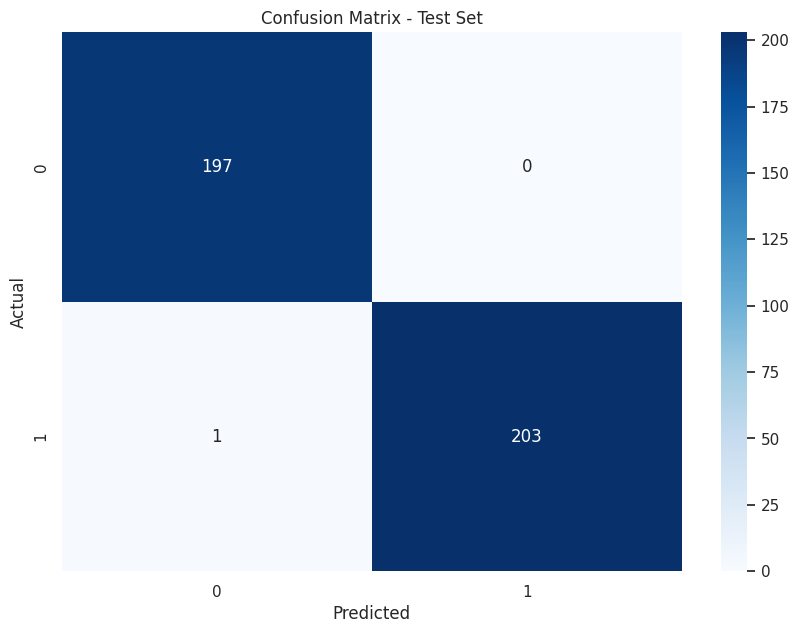

Testing DataLoader 0: 100%|██████████| 26/26 [00:00<00:00, 38.95it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │    0.9975062608718872     │
│          test/f1          │    0.9975429773330688     │
│         test/loss         │   0.003915686160326004    │
└───────────────────────────┴───────────────────────────┘

In [ ]:
trainer.test(model, data)

----